In [12]:
######################################CONSTANTS######################################
METRIC = 'calibration_error'
MODE = 'max'
HOLDOUT_RATIO = 0.1
RUNS = 100
LOG_FREQ = 100
threshold = 0.98  # threshold for x-axis cutoff


COLOR = {'non-active_no_prior': '#1f77b4',
         'ts_uniform': 'red',#'#ff7f0e',
         'ts_informed': 'green',
         'epsilon_greedy_no_prior': 'tab:pink',
         'bayesian_ucb_no_prior': 'cyan'

         }
COLOR = {'non-active': '#1f77b4',
         'ts': '#ff7f0e',
         'epsilon_greedy': 'pink',
         'bayesian_ucb': 'cyan'

         }
METHOD_NAME_DICT = {'non-active': 'Non-active',
                    'epsilon_greedy': 'Epsilon greedy',
                    'bayesian_ucb': 'Bayesian UCB',
                    'ts': 'TS'}
TOPK_METHOD_NAME_DICT = {'non-active': 'Non-active',
                         'epsilon_greedy': 'Epsilon greedy',
                         'bayesian_ucb': 'Bayesian UCB',
                         'ts': 'MP-TS'}

LINEWIDTH = 13.97


######################################CONSTANTS######################################
import sys

sys.path.insert(0, '..')
import argparse
from typing import Dict, Any

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

from data_utils import DATASIZE_DICT, FIGURE_DIR, RESULTS_DIR
from data_utils import DATASET_NAMES, TOPK_DICT

import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

RESULTS_DIR = RESULTS_DIR + 'active_learning_topk/'



In [13]:
def plot_topk_ece(ax: mpl.axes.Axes,
                  experiment_name: str,
                  topk: int,
                  eval_metric: str,
                  pool_size: int,
                  threshold: float) -> None:

    benchmark = 'ts'

    for method in METHOD_NAME_DICT:
        metric_eval = np.load(
            RESULTS_DIR + experiment_name + ('%s_%s.npy' % (eval_metric, method))).mean(axis=0)
        x = np.arange(len(metric_eval)) * LOG_FREQ / pool_size

        if topk == 1:
            label = METHOD_NAME_DICT[method]
        else:
            label = TOPK_METHOD_NAME_DICT[method]
        if method == 'non-active':
            linestyle = "-"
        else:
            linestyle = '-'
        ax.plot(x, metric_eval, linestyle, color=COLOR[method], label=label)

        if method == benchmark:
            if max(metric_eval) > threshold:
                cutoff = list(map(lambda i: i > threshold, metric_eval.tolist()[10:])).index(True) + 10
                cutoff = min(int(cutoff * 1.5), len(metric_eval) - 1)
            else:
                cutoff = len(metric_eval) - 1

    ax.set_xlim(0, cutoff * LOG_FREQ / pool_size)
    ax.set_ylim(0, 1.0)
    xmin, xmax = ax.get_xlim()
    step = ((xmax - xmin) / 4.0001)
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    ax.xaxis.set_ticks(np.arange(xmin, xmax + 0.001, step))
    ax.yaxis.set_ticks(np.arange(0, 1.01, 0.20))
    ax.tick_params(pad=0.25, length=1.5)

    return ax

In [14]:
def main(eval_metric: str, top1: bool, pseudocount: int, threshold: float) -> None:
    fig, axes = plt.subplots(ncols=len(TOPK_DICT), dpi=300, sharey=True)
    idx = 0
    for dataset in TOPK_DICT:
        print(dataset)
        if top1:
            topk = 1
        else:
            topk = TOPK_DICT[dataset]
        experiment_name = '%s_%s_%s_top%d_runs%d_pseudocount%.2f/' % \
                          (dataset, METRIC, MODE, topk, RUNS, pseudocount)
        plot_kwargs = {}
        plot_topk_ece(axes[idx],
                      experiment_name,
                      topk,
                      eval_metric,
                      int(DATASIZE_DICT[dataset] * (1 - HOLDOUT_RATIO)),
                      threshold=threshold)
        if topk == 1:
            axes[idx].set_title(DATASET_NAMES[dataset])
        else:
            axes[idx].set_xlabel("#queries")
        if idx > 0:
            axes[idx].tick_params(left=False)
        idx += 1

    axes[-1].legend()
    if topk == 1:
        axes[0].set_ylabel("MRR, top-1")
    else:
        axes[0].set_ylabel("MRR, top-m")
    fig.tight_layout()
    fig.set_size_inches(LINEWIDTH, 2.5)
    fig.subplots_adjust(bottom=0.05, wspace=0.20)

    if top1:
        figname = FIGURE_DIR + '%s_%s_%s_top1_pseudocount%d.pdf' % (METRIC, MODE, eval_metric, pseudocount)
    else:
        figname = FIGURE_DIR + '%s_%s_%s_topk_pseudocount%d.pdf' % (METRIC, MODE, eval_metric, pseudocount)
    fig.savefig(figname, bbox_inches='tight', pad_inches=0)

cifar100
imagenet


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/deepdata/bayesian_blackbox/output_from_datalab_20200204/output/active_learning_topk/imagenet_calibration_error_max_top1_runs100_pseudocount2.00/mrr_epsilon_greedy.npy'

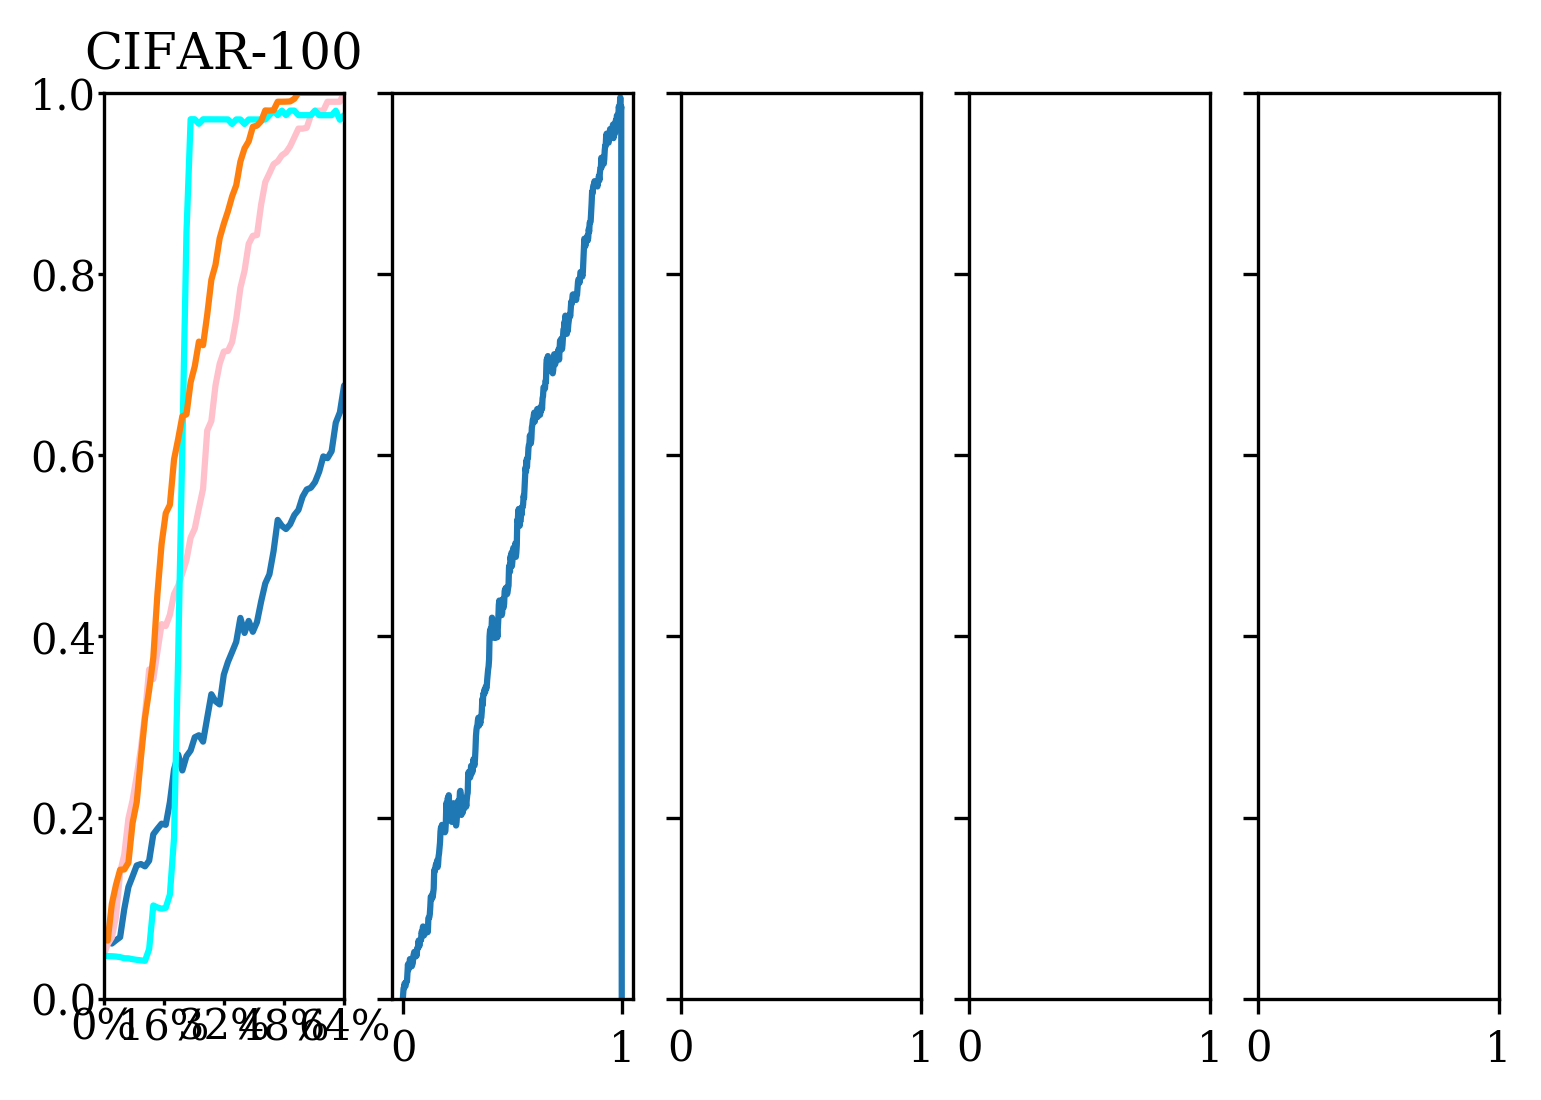

In [17]:
for pseudocount in [2, 5, 10]:
    for eval_metric in ['avg_num_agreement', 'mrr']:
        for top1 in [True, False]:
            main(eval_metric, top1, pseudocount, threshold)